# Bike Sharing Demand

## 컬럼 설명

  * **datetime** - 시간. 연-월-일 시:분:초 로 표현합니다. (가령 2011-01-01 00:00:00은 2011년 1월 1일 0시 0분 0초)
  * **season** - 계절. 봄(1), 여름(2), 가을(3), 겨울(4) 순으로 표현합니다.
  * **holiday** - 공휴일. 1이면 공휴일이며, 0이면 공휴일이 아닙니다.
  * **workingday** - 근무일. 1이면 근무일이며, 0이면 근무일이 아닙니다.
  * **weather** - 날씨. 1 ~ 4 사이의 값을 가지며, 구체적으로는 다음과 같습니다.
    * 1: 아주 깨끗한 날씨입니다. 또는 아주 약간의 구름이 끼어있습니다.
    * 2: 약간의 안개와 구름이 끼어있는 날씨입니다.
    * 3: 약간의 눈, 비가 오거나 천둥이 칩니다.
    * 4: 아주 많은 비가 오거나 우박이 내립니다.
  * **temp** - 온도. 섭씨(Celsius)로 적혀있습니다.
  * **atemp** - 체감 온도. 마찬가지로 섭씨(Celsius)로 적혀있습니다.
  * **humidity** - 습도.
  * **windspeed** - 풍속.
  * **casual** - 비회원(non-registered)의 자전거 대여량.
  * **registered** - 회원(registered)의 자전거 대여량.
  * **count** - 총 자전거 대여랑. 비회원(casual) + 회원(registered)과 동일합니다.

## 필요한 라이브러리

In [1]:
#데이터 관련
import pandas as pd
import numpy as np
#머신러닝
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
#시각화 관련 라이브러리
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
# warning 무시하기
import warnings
warnings.filterwarnings('ignore')

## 데이터 불러오기

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
train.shape

(10886, 12)

In [4]:
test.shape

(6493, 9)

## Preprocessing

### 날짜

In [5]:
#object를 datetime 타입으로 to_datetime()
train["datetime"] = pd.to_datetime(train["datetime"])
train.dtypes

datetime      datetime64[ns]
season                 int64
holiday                int64
workingday             int64
weather                int64
temp                 float64
atemp                float64
humidity               int64
windspeed            float64
casual                 int64
registered             int64
count                  int64
dtype: object

In [6]:
#년,월,일,날짜,시간,분,초로 나누기
train["year"] = train["datetime"].dt.year
train["month"] = train["datetime"].dt.month
train["day"] = train["datetime"].dt.day
train["hour"] = train["datetime"].dt.hour
train["minute"] = train["datetime"].dt.minute
train["second"] = train["datetime"].dt.second
train["dayofweek"] = train["datetime"].dt.dayofweek
#saturday, sunday와 같이 문자로 나타내기 위해서는 밑에 메소드
#train["datetime-dayofweek"] = train["datetime"].dt.day_name()

#확인
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,minute,second,dayofweek
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,0,0,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,0,0,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,0,0,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3,0,0,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4,0,0,5


In [7]:
#test도 바꿔주기
test["datetime"] = pd.to_datetime(test["datetime"])
test["year"] = test["datetime"].dt.year
test["month"] = test["datetime"].dt.month
test["day"] = test["datetime"].dt.day
test["hour"] = test["datetime"].dt.hour
test["minute"] = test["datetime"].dt.minute
test["second"] = test["datetime"].dt.second
test["dayofweek"] = test["datetime"].dt.dayofweek

#확인
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,hour,minute,second,dayofweek
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,2011,1,20,0,0,0,3
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,1,0,0,3
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,2,0,0,3
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20,3,0,0,3
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20,4,0,0,3


## Explore

### datetime

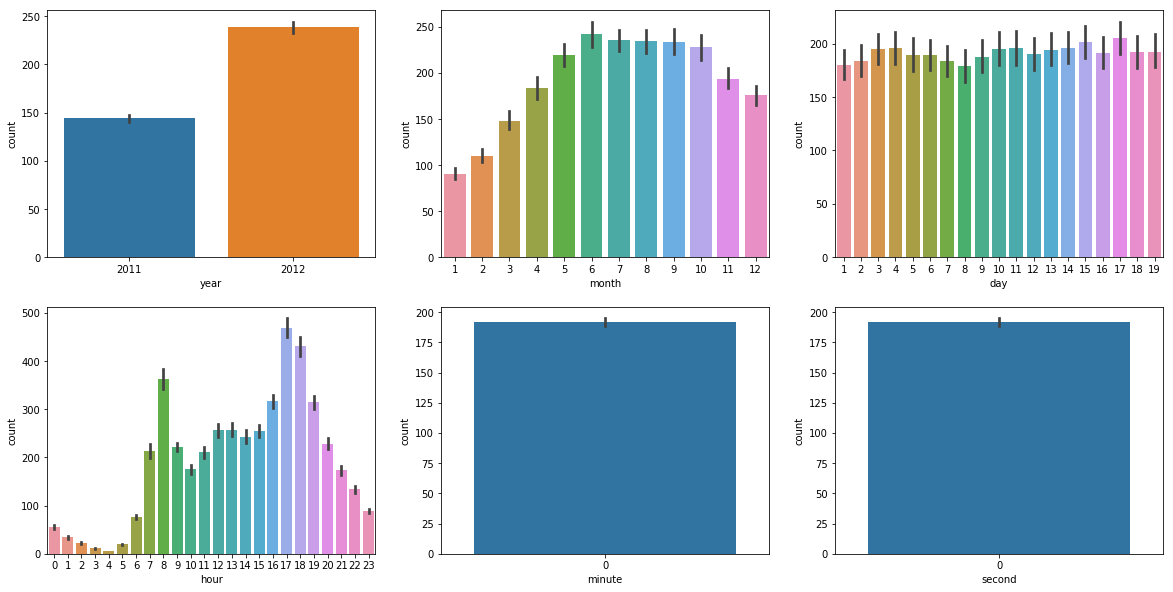

In [8]:
#시각화 박스 생성
figure, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3)
# 시각화 사이즈 설정
figure.set_size_inches(20, 10)
# 연, 월, 일, 시, 분, 초 별 자전거 대여량을 출력
sns.barplot(data=train, x="year", y="count", ax=ax1)
sns.barplot(data=train, x="month", y="count", ax=ax2)
sns.barplot(data=train, x="day", y="count", ax=ax3)
sns.barplot(data=train, x="hour", y="count", ax=ax4)
sns.barplot(data=train, x="minute", y="count", ax=ax5)
sns.barplot(data=train, x="second", y="count", ax=ax6)

**day, minute, second**
 * 데이터가 부족하고, 분석이 도움이 되지 않을거 같으니 빼기

### weather 컬럼 분석

  * 1: 아주 깨끗한 날씨입니다. 또는 아주 약간의 구름이 끼어있습니다.
  * 2: 약간의 안개와 구름이 끼어있는 날씨입니다.
  * 3: 약간의 눈, 비가 오거나 천둥이 칩니다.
  * 4: 아주 많은 비가 오거나 우박이 내립니다.

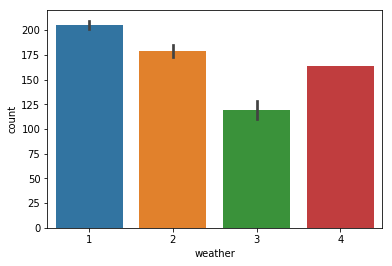

In [9]:
#날씨(weather) 데이터를 시각화
sns.barplot(data=train, x="weather", y="count")

### windspeed

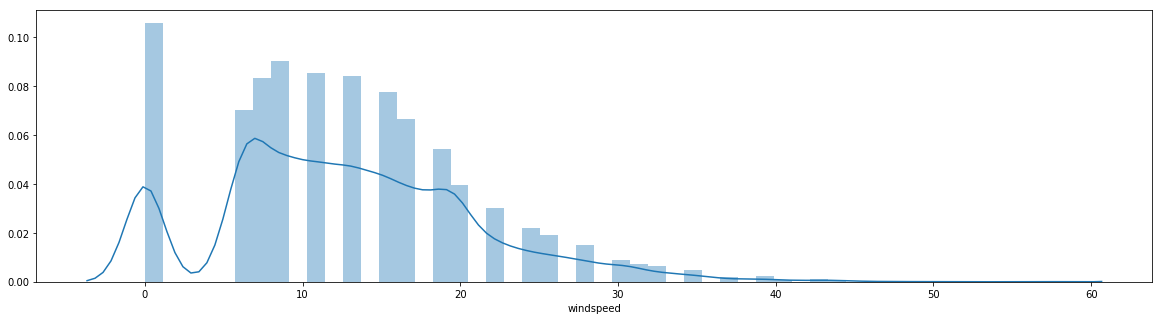

In [10]:
# windspeed distplot 데이터 시각화
plt.figure(figsize = (20, 5))
sns.distplot(train["windspeed"])

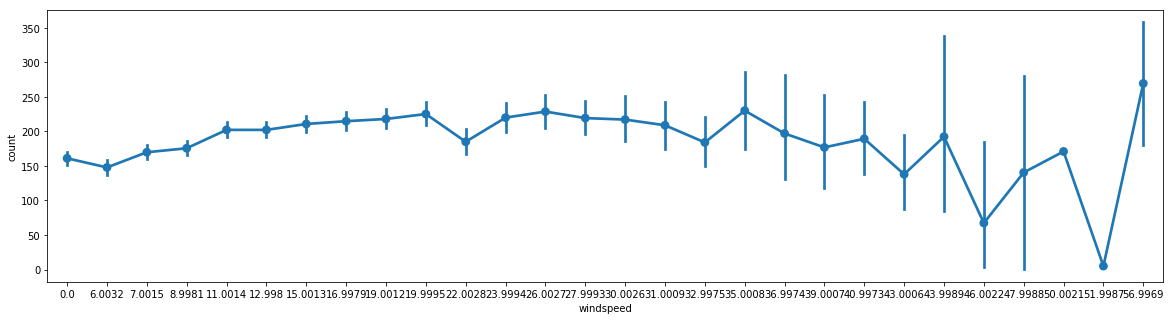

In [11]:
plt.figure(figsize = (20, 5))
sns.pointplot(data = train, x="windspeed", y="count")

# 풍속은 일단 보류

### 풍속 0 채우기

In [ ]:
wind_feature = ["season", "weather", "humidity", "month", "temp", "year", "atemp"]
nowind = test[test['windspeed']== 0]
yeswind = test[test['windspeed'] != 0]
yeswind_x = yeswind[wind_feature]
yeswind_y = yeswind['windspeed']
nowind_x = nowind[wind_feature]
wind_model = RandomForestRegressor()
wind_model.fit(yeswind_x,yeswind_y)
wind_predict = wind_model.predict(nowind_x)
test[test['windspeed'] == 0]['windspeed']  = wind_predict

def predict_windspeed(data,wind_feature):
    wind_feature = ["season", "weather", "humidity", "month", "temp", "year", "atemp"]
    nowind = data[data['windspeed'] == 0]
    yeswind = data[data['windspeed'] != 0]
    rfModel_wind = RandomForestRegressor()
    rfModel_wind.fit(yeswind[wind_feature], yeswind["windspeed"])
    nowind_value = rfModel_wind.predict(X = nowind[wind_feature])
    nowind["windspeed"] = nowind_value
    data = yeswind.append(nowind)
    data.reset_index(inplace=True)
    data.drop('index', inplace=True, axis=1)
    return data

#풍속을 머신러닝으로 채우는 함수 만들기
def fill_windspeed(data, wind_feature):
    nowind = data[data['windspeed']== 0]
    yeswind = data[data['windspeed'] != 0]
    yeswind_x = yeswind[wind_feature]
    yeswind_y = yeswind['windspeed']
    nowind_x = nowind[wind_feature]
    wind_model = RandomForestRegressor()
    wind_model.fit(yeswind_x,yeswind_y)
    wind_predict = wind_model.predict(nowind_x)
    data[data['windspeed']== 0]['windspeed'] = wind_predict
    return data

---

### temp

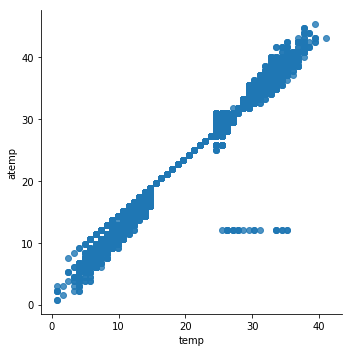

In [12]:
# 온도(temp)와 체감온도(atemp)의 상관관계를 시각화
sns.lmplot(data=train, x="temp", y="atemp", fit_reg=False)

### dayofweek 컬럼 시각화하기

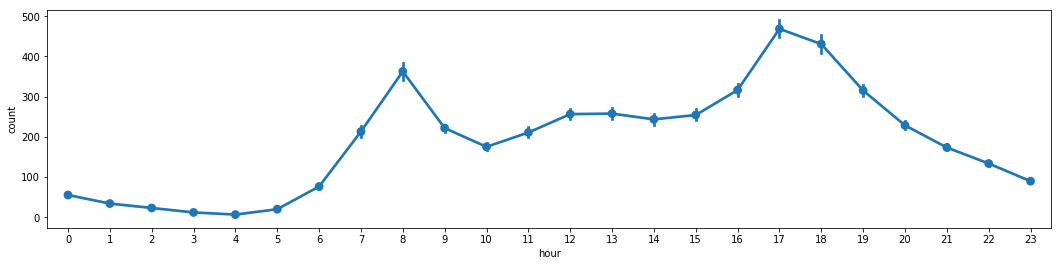

In [13]:
# 시간(datetime-hour)에 따른 자전거 변화량을 시각화
plt.figure(figsize = (20, 5))
sns.pointplot(data=train, x="hour", y="count")

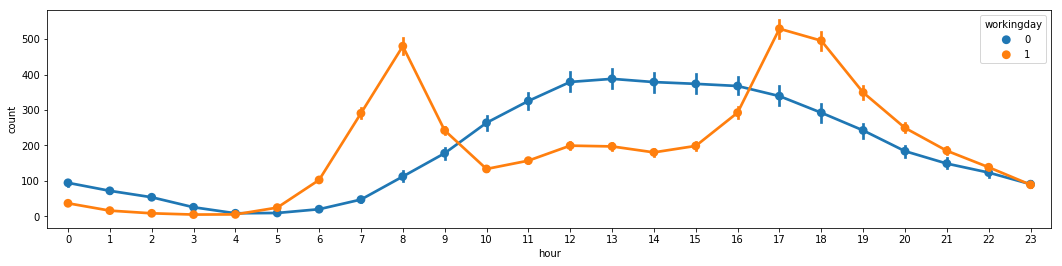

In [14]:
# workingday와 datetime-hour에 따른 자전거 변화량을 시각화
plt.figure(figsize = (20, 5))
sns.pointplot(data=train, x="hour", y="count", hue="workingday")

### casual과 registered 컬럼 시각화하기

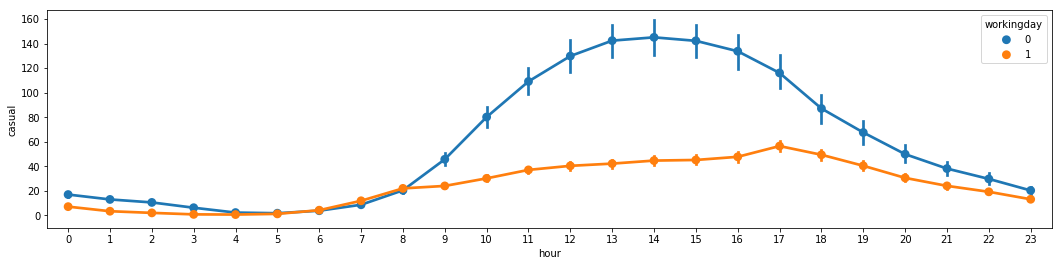

In [16]:
# seaborn의 pointplot으로 근무일 여부(workingday)와 시간(datetime-hour)에 따른 비회원의 자전거 변화량(casual)을 시각화합니다.
plt.figure(figsize = (18, 4))
sns.pointplot(data=train, x="hour", y="casual", hue="workingday")

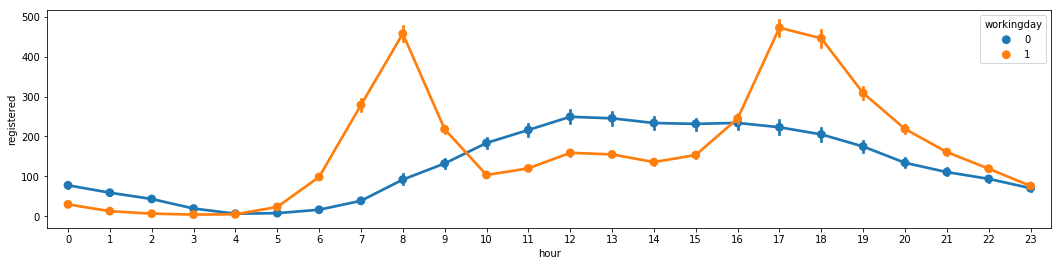

In [17]:
# seaborn의 pointplot으로 근무일 여부(workingday)와 시간(datetime-hour)에 따른 회원의 자전거 변화량(registered)을 시각화합니다.
plt.figure(figsize = (20, 5))
sns.pointplot(data=train, x="hour", y="registered", hue="workingday")

## Train

In [18]:
train.drop(['minute','second','datetime','day'],axis = 1, inplace = True)
train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,hour,dayofweek
0,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,0,5
1,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,5
2,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,2,5
3,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,3,5
4,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,4,5


In [19]:
#왜 카테고리로 해야하나?
categorical_feature_names = ['dayofweek','weather','season','holiday','workingday','weather','year','hour']
for var in categorical_feature_names:
    train[var] = train[var].astype("category")
    test[var] = test[var].astype("category")

In [20]:
#풍속을 0을 아직 처리하지 않았습니다. 
#추후하려고 합니다. 아직 0을 처리하지 않아서 그런지 풍속을 뺐을 때가 결과가 더 좋더라고요. 넣어도 합격점을 넘는데는 문제 없었습니다.
feature_names = ["season", "holiday", "workingday", "weather",
                 "temp", "atemp", "humidity", "windspeed",
                 "year", "hour", "dayofweek"]

In [21]:
x_train = train[feature_names]

In [22]:
x_test = test[feature_names]

In [23]:
label_name = 'count'
y_train = train[label_name]
y_train_count = train[label_name]

In [24]:
# y_train_count에 log + 1 연산을 합니다.
# 이를 y_train_log_count라는 이름의 변수에 할당합니다.
y_train_log_count = np.log(y_train_count + 1)

# y_train_log_count 변수에 할당된 데이터의 사이즈를 출력합니다.
# 출력은 (row, column) 으로 표시되나, column이 없기 때문에 (row,) 형태로 표시될 것입니다.
print(y_train_log_count.shape)

# y_train_log_count 데이터의 상위 5개를 띄웁니다.
y_train_log_count.head()

(10886,)


0    2.833213
1    3.713572
2    3.496508
3    2.639057
4    0.693147
Name: count, dtype: float64

In [25]:
# train 데이터의 두 번째 label에 해당하는 비회원의 자전거 대여량(casual)을 가져옵니다.
# 이를 y_train_casual이라는 이름의 변수에 할당합니다.
y_train_casual = train["casual"]

# y_train_casual 변수에 할당된 데이터의 사이즈를 출력합니다.
# 출력은 (row, column) 으로 표시되나, column이 없기 때문에 (row,) 형태로 표시될 것입니다.
print(y_train_casual.shape)

# y_train_casual 데이터의 상위 5개를 띄웁니다.
y_train_casual.head()

(10886,)


0    3
1    8
2    5
3    3
4    0
Name: casual, dtype: int64

In [26]:
# y_train_casual에 log + 1 연산을 합니다.
# 이를 y_train_log_casual라는 이름의 변수에 할당합니다.
y_train_log_casual = np.log(y_train_casual + 1)

# y_train_log_casual 변수에 할당된 데이터의 사이즈를 출력합니다.
# 출력은 (row, column) 으로 표시되나, column이 없기 때문에 (row,) 형태로 표시될 것입니다.
print(y_train_log_casual.shape)

# y_train_log_casual 데이터의 상위 5개를 띄웁니다.
y_train_log_casual.head()

(10886,)


0    1.386294
1    2.197225
2    1.791759
3    1.386294
4    0.000000
Name: casual, dtype: float64

In [27]:
# train 데이터의 세 번째 label에 해당하는 회원의 자전거 대여량(registered)을 가져옵니다.
# 이를 y_train_registered이라는 이름의 변수에 할당합니다.
y_train_registered = train["registered"]

# y_train_registered 변수에 할당된 데이터의 사이즈를 출력합니다.
# 출력은 (row, column) 으로 표시되나, column이 없기 때문에 (row,) 형태로 표시될 것입니다.
print(y_train_registered.shape)

# y_train_registered 데이터의 상위 5개를 띄웁니다.
y_train_registered.head()

(10886,)


0    13
1    32
2    27
3    10
4     1
Name: registered, dtype: int64

In [28]:
# y_train_registered에 log + 1 연산을 합니다.
# 이를 y_train_log_registered라는 이름의 변수에 할당합니다.
y_train_log_registered = np.log(y_train_registered + 1)

# y_train_log_registered 변수에 할당된 데이터의 사이즈를 출력합니다.
# 출력은 (row, column) 으로 표시되나, column이 없기 때문에 (row,) 형태로 표시될 것입니다.
print(y_train_log_registered.shape)

# y_train_log_registered 데이터의 상위 5개를 띄웁니다.
y_train_log_registered.head()

(10886,)


0    2.639057
1    3.496508
2    3.332205
3    2.397895
4    0.693147
Name: registered, dtype: float64

### Use Random Forest

In [41]:
# scikit-learn 패키지의 ensemble 모듈에 있는 RandomForestRegressor를 가지고 옵니다.
from sklearn.ensemble import RandomForestRegressor

# RandomForestRegressor를 생성합니다. 실행할 때는 다음의 옵션이 들어갑니다.
# 1) n_estimators. 트리의 개수입니다. 10을 넣으면 10개의 트리를 생성합니다.
# 2) n_jobs. 병렬처리 여부입니다. -1을 대입하면 컴퓨터에 존재하는 모든 코어(Core, ex: 듀얼코어, 쿼드코어)를 전부 활용합니다.
# 3) random_state. 랜덤포레스트의 결과가 랜덤하게 나오는 것을 고정하는 옵션입니다. 아무 숫자나 넣어주면 됩니다. (공학 용어에서 쓰이는 Seed Number와 동일한 개념입니다)
model = RandomForestRegressor(n_estimators=10,
                              n_jobs=-1,
                              random_state=37)
model

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=37, verbose=0, warm_start=False)

## Hyperparameter Tuning

### Random Search(Coarse)

In [42]:
# 파이썬의 선형대수 패키지인 Numpy를 가져옵니다.
# 이를 줄여서 np라는 축약어로 사용합니다.
import numpy as np

# scikit-learn 패키지의 ensemble 모듈에 있는 RandomForestRegressor를 가지고 옵니다.
from sklearn.ensemble import RandomForestRegressor

# scikit-learn 패키지의 model_selection 모듈에 있는 cross_val_predict 함수를 가지고 옵니다.
from sklearn.model_selection import cross_val_predict

# scikit-learn의 metrics 모듈에서 mean_squared_log_error라는 이름의 함수를 가져옵니다.
# 이 함수는 앞서 설명한 RMSLE에서 R(Root)를 제외한 나머지 부분을 계산해줍니다.
from sklearn.metrics import mean_squared_log_error

# n_estimators는 트리의 갯수입니다.
# 보통은 높을수록 좋지만, 그만큼 실행 속도가 오래 걸리기 때문에 이번에는 적당한 값을 주겠습니다. (300 개)
# 나머지 하이퍼패리미터가 전부 튜닝되면, 그 다음에는 n_estimators를 최대한 높이 주면 됩니다. (ex: 1,000 개)
n_estimators = 300

# 랜덤 서치를 반복할 횟수입니다.
# 보통 100번을 반복합니다.
num_epoch = 100

# hyperparameter 탐색 결과를 리스트로 저장합니다.
coarse_hyperparameters_list = []

# num_epoch 횟수만큼 랜덤 서치를 반복합니다.
for epoch in range(num_epoch):
    # 2에서 100 사이의 정수형(int) 값을 랜덤하게 생성하여 max_depth 변수에 할당합니다.
    max_depth = np.random.randint(low = 2, high = 100)

    # 0.1에서 1.0 사이의 실수형(float) 값을 랜덤하게 생성하여  max_features 변수에 할당합니다.
    max_features = np.random.uniform(low = 0.1, high = 1.0)

    # Random Forest를 생성합니다. 옵션은 다음과 같습니다.
    # 1) n_estimators. 트리의 갯수입니다.
    # 2) max_depth. 트리의 깊이입니다. 지정한 숫자만큼 트리가 깊게 가지를 뻗습니다.
    # 3) max_features. Feature Sampling입니다. 0.0 ~ 1.0 사이의 값을 넣으면, 트리를 생성할 때 전체 feature에서 지정한 비율만큼만 feature를 사용합니다.
    # 4) n_jobs. 병렬처리 여부입니다. -1을 대입하면 컴퓨터에 존재하는 모든 코어(Core, ex: 듀얼코어, 쿼드코어)를 전부 활용합니다.
    # 5) random_state. 랜덤포레스트의 결과가 랜덤하게 나오는 것을 고정하는 옵션입니다. 아무 숫자나 넣어주면 됩니다. (공학 용어에서 쓰이는 Seed Number와 동일한 개념입니다)
    model = RandomForestRegressor(n_estimators = n_estimators,
                                  max_depth = max_depth,
                                  max_features = max_features,
                                  n_jobs = -1,
                                  random_state = 37)

    # 주어진 모델(랜덤포레스트)를 활용하여 Cross Validation을 합니다.
    # Cross Validation을 할 때는 cross_val_predict라는 함수를 사용하며, 이 함수에는 다음의 옵션이 들어갑니다.
    # 1) model. 점수를 측정할 머신러닝 모델(현재는 Random Forest)이 들어갑니다.
    # 2) X_train. train 데이터의 feature 입니다.
    # 3) y_train. train 데이터의 label 입니다.
    # 4) cv. Cross Validation에서 데이터를 조각낼(split) 갯수입니다. 총 20조각을 내야하기 때문에 20을 대입합니다.
    # 단, 이 Cross Validation을 할 때는 count 컬럼 하나를 사용하는게 아니라,
    # count, casual, registered 컬럼 세 개를 따로 예측합니다.
    # 또한 count, casual, registered 세 개를 그냥 사용하지 않고, log + 1 연산을 한 결과를 사용합니다.
    y_predict_log_casual = cross_val_predict(model, X_train, y_train_log_casual, cv = 20)
    y_predict_log_registered = cross_val_predict(model, X_train, y_train_log_registered, cv = 20)
    y_predict_log_count = cross_val_predict(model, X_train, y_train_log_count, cv = 20)

    # 위 Cross Validation을 통해 얻은 예측값을, exp - 1 연산을 함으로서
    # 다시 원래 자전거 대여량으로 변환시킵니다.
    y_predict_casual = np.exp(y_predict_log_casual) - 1
    y_predict_registered = np.exp(y_predict_log_registered) - 1
    y_predict_count = np.exp(y_predict_log_count) - 1

    # 이 결과를 기하평균을 통해 하나로 합칩니다.
    # 이렇게 하면 결과적으로 train 데이터의 자전거 대여량의 예측값이 나옵니다.
    # 이 예측값을 y_predict라는 변수에 할당합니다.
    y_predict = np.sqrt((y_predict_casual + y_predict_registered) * y_predict_count)

    # train 데이터의 label에 해당하는 y_train과, train 데이터의 label의 예측값인 y_predict를 활용하여
    # Mean Squared Logarithmic Error(MSLE)를 계산합니다.
    # 이후 여기에 numpy의 sqrt(square root)를 활용하여 루트 연산을 합니다.
    # 이 결과가 사실상 Root Mean Squared Logarithmic Error(RMSLE)가 됩니다.
    # 이를 score라는 이름의 변수에 할당합니다.
    score = mean_squared_log_error(y_train_count, y_predict)
    score = np.sqrt(score)
    
    # hyperparameter 탐색 결과를 딕셔너리화 합니다.
    hyperparameters = {
        'epoch': epoch,
        'score': score,
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'max_features': max_features,
    }

    # hyperparameter 탐색 결과를 리스트에 저장합니다.
    coarse_hyperparameters_list.append(hyperparameters)

    # hyperparameter 탐색 결과를 출력합니다.
    print(f"{epoch:2} n_estimators = {n_estimators}, max_depth = {max_depth:2}, max_features = {max_features:.6f}, Score = {score:.5f}")

# coarse_hyperparameters_list를 Pandas의 DataFrame으로 변환합니다.
coarse_hyperparameters_list = pd.DataFrame.from_dict(coarse_hyperparameters_list)

# 변환한 coarse_hyperparameters_list를 score가 낮은 순으로 정렬합니다.
# (RMSE는 score가 낮을 수록 더 정확도가 높다고 가정합니다)
coarse_hyperparameters_list = coarse_hyperparameters_list.sort_values(by="score")

# coarse_hyperparameters_list 변수에 할당된 데이터의 행렬 사이즈를 출력합니다.
# 출력은 (row, column) 으로 표시됩니다.
print(coarse_hyperparameters_list.shape)

# coarse_hyperparameters_list의 상위 10개를 출력합니다.
coarse_hyperparameters_list.head(10)

 0 n_estimators = 300, max_depth =  7, max_features = 0.564376, Score = 0.49390
 1 n_estimators = 300, max_depth = 88, max_features = 0.576880, Score = 0.35183
 2 n_estimators = 300, max_depth = 23, max_features = 0.711858, Score = 0.34633
 3 n_estimators = 300, max_depth = 86, max_features = 0.491072, Score = 0.36117
 4 n_estimators = 300, max_depth = 55, max_features = 0.827105, Score = 0.34346
 5 n_estimators = 300, max_depth = 33, max_features = 0.806518, Score = 0.34387
 6 n_estimators = 300, max_depth = 23, max_features = 0.284741, Score = 0.42157
 7 n_estimators = 300, max_depth = 44, max_features = 0.594054, Score = 0.35183
 8 n_estimators = 300, max_depth = 13, max_features = 0.155967, Score = 0.62202
 9 n_estimators = 300, max_depth =  5, max_features = 0.198825, Score = 0.79497
10 n_estimators = 300, max_depth = 57, max_features = 0.510465, Score = 0.36117
11 n_estimators = 300, max_depth = 38, max_features = 0.349055, Score = 0.42003
12 n_estimators = 300, max_depth =  6, m

/Users/hajae/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/Users/hajae/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/Users/hajae/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/Users/hajae/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/extern

KeyboardInterrupt: 

Coarse Search가 끝났으면, 상위 5 ~ 10개의 결과만 출력한 뒤 이 결과를 낸 하이퍼패러미터 범위만 남겨놓고 다시 한 번 Random Search를 합니다. 이를 Fine Search라고 합니다.

가령 위 Coarse Search를 통해, 다음의 하이퍼패러미터가 상위 5 ~ 10개 안에 들었다고 가정하겠습니다.

  * max_depth = 40개 ~ 100개
  * max_features = 0.7 ~ 1.0
  
이제 위 코드를 그대로 사용하되, 다음의 부분만 수정한 뒤 다시 한 번 Random Search를 하겠습니다.

```
# 40에서 100 사이의 정수형(int) 값을 랜덤하게 생성하여 max_depth 변수에 할당합니다.
max_depth = np.random.randint(low=40, high=100)

# 0.6에서 1.0 사이의 실수형(float) 값을 랜덤하게 생성하여  max_features 변수에 할당합니다.
max_features = np.random.uniform(low=0.7, high=1.0) 
```

In [48]:
# coarse_hyperparameters_list를 Pandas의 DataFrame으로 변환합니다.
coarse_hyperparameters_list = pd.DataFrame.from_dict(coarse_hyperparameters_list)

# 변환한 coarse_hyperparameters_list를 score가 낮은 순으로 정렬합니다.
# (RMSE는 score가 낮을 수록 더 정확도가 높다고 가정합니다)
coarse_hyperparameters_list = coarse_hyperparameters_list.sort_values(by="score")

# coarse_hyperparameters_list 변수에 할당된 데이터의 행렬 사이즈를 출력합니다.
# 출력은 (row, column) 으로 표시됩니다.
print(coarse_hyperparameters_list.shape)

# coarse_hyperparameters_list의 상위 10개를 출력합니다.
coarse_hyperparameters_list.head(50)

(90, 5)


,epoch,max_depth,max_features,n_estimators,score
56,56,66,0.881468,300,0.343461
4,4,55,0.827105,300,0.343461
23,23,63,0.889189,300,0.343461
50,50,38,0.868148,300,0.343461
29,29,24,0.778240,300,0.343760
78,78,29,0.737649,300,0.343818
43,43,71,0.806776,300,0.343855
13,13,90,0.748760,300,0.343855
14,14,73,0.803694,300,0.343855
74,74,80,0.809018,300,0.343855


### Random Search(Fine)

In [49]:
# 파이썬의 선형대수 패키지인 Numpy를 가져옵니다.
# 이를 줄여서 np라는 축약어로 사용합니다.
import numpy as np

# scikit-learn 패키지의 ensemble 모듈에 있는 RandomForestRegressor를 가지고 옵니다.
from sklearn.ensemble import RandomForestRegressor

# scikit-learn 패키지의 model_selection 모듈에 있는 cross_val_predict 함수를 가지고 옵니다.
from sklearn.model_selection import cross_val_predict

# scikit-learn의 metrics 모듈에서 mean_squared_log_error라는 이름의 함수를 가져옵니다.
# 이 함수는 앞서 설명한 RMSLE에서 R(Root)를 제외한 나머지 부분을 계산해줍니다.
from sklearn.metrics import mean_squared_log_error

# n_estimators는 트리의 갯수입니다.
# 보통은 높을수록 좋지만, 그만큼 실행 속도가 오래 걸리기 때문에 이번에는 적당한 값을 주겠습니다. (300 개)
# 나머지 하이퍼패리미터가 전부 튜닝되면, 그 다음에는 n_estimators를 최대한 높이 주면 됩니다. (ex: 1,000 개)
n_estimators = 300

# 랜덤 서치를 반복할 횟수입니다.
# 보통 100번을 반복합니다.
num_epoch = 100

# hyperparameter 탐색 결과를 리스트로 저장합니다.
fine_hyperparameters_list = []

# num_epoch 횟수만큼 랜덤 서치를 반복합니다.
for epoch in range(num_epoch):
    # 40에서 100 사이의 정수형(int) 값을 랜덤하게 생성하여 max_depth 변수에 할당합니다.
    max_depth = np.random.randint(low = 40, high = 90)

    # 0.6에서 1.0 사이의 실수형(float) 값을 랜덤하게 생성하여  max_features 변수에 할당합니다.
    max_features = np.random.uniform(low = 0.8, high = 1.0)

    # Random Forest를 생성합니다. 옵션은 다음과 같습니다.
    # 1) n_estimators. 트리의 갯수입니다.
    # 2) max_depth. 트리의 깊이입니다. 지정한 숫자만큼 트리가 깊게 가지를 뻗습니다.
    # 3) max_features. Feature Sampling입니다. 0.0 ~ 1.0 사이의 값을 넣으면, 트리를 생성할 때 전체 feature에서 지정한 비율만큼만 feature를 사용합니다.
    # 4) n_jobs. 병렬처리 여부입니다. -1을 대입하면 컴퓨터에 존재하는 모든 코어(Core, ex: 듀얼코어, 쿼드코어)를 전부 활용합니다.
    # 5) random_state. 랜덤포레스트의 결과가 랜덤하게 나오는 것을 고정하는 옵션입니다. 아무 숫자나 넣어주면 됩니다. (공학 용어에서 쓰이는 Seed Number와 동일한 개념입니다)
    model = RandomForestRegressor(n_estimators = n_estimators,
                                  max_depth = max_depth,
                                  max_features = max_features,
                                  n_jobs = -1,
                                  random_state = 37)

    # 주어진 모델(랜덤포레스트)를 활용하여 Cross Validation을 합니다.
    # Cross Validation을 할 때는 cross_val_predict라는 함수를 사용하며, 이 함수에는 다음의 옵션이 들어갑니다.
    # 1) model. 점수를 측정할 머신러닝 모델(현재는 Random Forest)이 들어갑니다.
    # 2) X_train. train 데이터의 feature 입니다.
    # 3) y_train. train 데이터의 label 입니다.
    # 4) cv. Cross Validation에서 데이터를 조각낼(split) 갯수입니다. 총 20조각을 내야하기 때문에 20을 대입합니다.
    # 단, 이 Cross Validation을 할 때는 count 컬럼 하나를 사용하는게 아니라,
    # count, casual, registered 컬럼 세 개를 따로 예측합니다.
    # 또한 count, casual, registered 세 개를 그냥 사용하지 않고, log + 1 연산을 한 결과를 사용합니다.
    y_predict_log_casual = cross_val_predict(model, X_train, y_train_log_casual, cv = 20)
    y_predict_log_registered = cross_val_predict(model, X_train, y_train_log_registered, cv = 20)
    y_predict_log_count = cross_val_predict(model, X_train, y_train_log_count, cv = 20)

    # 위 Cross Validation을 통해 얻은 예측값을, exp - 1 연산을 함으로서
    # 다시 원래 자전거 대여량으로 변환시킵니다.
    y_predict_casual = np.exp(y_predict_log_casual) - 1
    y_predict_registered = np.exp(y_predict_log_registered) - 1
    y_predict_count = np.exp(y_predict_log_count) - 1

    # 이 결과를 기하평균을 통해 하나로 합칩니다.
    # 이렇게 하면 결과적으로 train 데이터의 자전거 대여량의 예측값이 나옵니다.
    # 이 예측값을 y_predict라는 변수에 할당합니다.
    y_predict = np.sqrt((y_predict_casual + y_predict_registered) * y_predict_count)
    
    # hyperparameter 탐색 결과를 딕셔너리화 합니다.
    hyperparameters = {
        'epoch': epoch,
        'score': score,
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'max_features': max_features,
    }

    # hyperparameter 탐색 결과를 리스트에 저장합니다.
    fine_hyperparameters_list.append(hyperparameters)

    # hyperparameter 탐색 결과를 출력합니다.
    print(f"{epoch:2} n_estimators = {n_estimators}, max_depth = {max_depth:2}, max_features = {max_features:.6f}, Score = {score:.5f}")

# fine_hyperparameters_list를 Pandas의 DataFrame으로 변환합니다.
fine_hyperparameters_list = pd.DataFrame.from_dict(fine_hyperparameters_list)

# 변환한 fine_hyperparameters_list를 score가 낮은 순으로 정렬합니다.
# (RMSE는 score가 낮을 수록 더 정확도가 높다고 가정합니다)
fine_hyperparameters_list = fine_hyperparameters_list.sort_values(by="score")

# fine_hyperparameters_list 변수에 할당된 데이터의 행렬 사이즈를 출력합니다.
# 출력은 (row, column) 으로 표시됩니다.
print(fine_hyperparameters_list.shape)

# fine_hyperparameters_list의 상위 10개를 출력합니다.
fine_hyperparameters_list.head(10)

 0 n_estimators = 300, max_depth = 78, max_features = 0.870329, Score = 0.34446
 1 n_estimators = 300, max_depth = 60, max_features = 0.976627, Score = 0.34446
 2 n_estimators = 300, max_depth = 84, max_features = 0.916766, Score = 0.34446
 3 n_estimators = 300, max_depth = 69, max_features = 0.828871, Score = 0.34446
 4 n_estimators = 300, max_depth = 43, max_features = 0.995672, Score = 0.34446
 5 n_estimators = 300, max_depth = 80, max_features = 0.882858, Score = 0.34446
 6 n_estimators = 300, max_depth = 84, max_features = 0.927784, Score = 0.34446
 7 n_estimators = 300, max_depth = 58, max_features = 0.989507, Score = 0.34446
 8 n_estimators = 300, max_depth = 79, max_features = 0.904869, Score = 0.34446
 9 n_estimators = 300, max_depth = 40, max_features = 0.816922, Score = 0.34446
10 n_estimators = 300, max_depth = 57, max_features = 0.963409, Score = 0.34446
11 n_estimators = 300, max_depth = 49, max_features = 0.946054, Score = 0.34446
12 n_estimators = 300, max_depth = 65, m

KeyboardInterrupt: 

탐색 결과 다음의 하이퍼패러미터가 가장 좋은 하이퍼패러미터라는 사실을 발견할 수 있습니다.

In [ ]:
# 가장 score가 낮게 나온(=좋은 정확도가 나온) 하이퍼패러미터를 가져옵니다.
# 이를 best_hyperparameters라는 이름의 변수에 저장합니다.
best_hyperparameters = fine_hyperparameters_list.iloc[0]

# best_hyperparameters에서 max_depth 하이퍼패러미터만 가져옵니다.
# 이를 best_max_depth라는 이름의 변수에 저장합니다.
best_max_depth = best_hyperparameters["max_depth"]

# best_hyperparameters에서 max_features 하이퍼패러미터만 가져옵니다.
# 이를 best_max_features라는 이름의 변수에 저장합니다.
best_max_features = best_hyperparameters["max_features"]

# best_max_depth와 best_max_features를 출력합니다.
print(f"max_depth(best) = {best_max_depth}, max_features(best) = {best_max_features:.6f}")

## Predict

머신러닝 알고리즘을 성공적으로 학습시켰다면, 남은 것은 이 알고리즘을 활용해 test 데이터에 있는 자전거 대여량을  예측하는 것입니다. 예측은 ```model.predict```로 할 수 있으며, 이 때 test 데이터의 feature인 ```X_test```가 필요합니다.

In [29]:
# 하이퍼패러미터 튜닝이 끝났으면, 이제 n_estimators를 가능한 높은 값을 주겠습니다.
best_n_estimators = 5000

# 주의: 혹시 하이퍼패러미터 튜닝을 하는데 시간이 너무 오래 걸린다면,
# 이를 대신해서 다음의 하이퍼패러미터를 사용해주세요. (아래 두 줄의 주석을 풀면 됩니다)
# best_max_depth = 97
# best_max_features = 0.897703
        
# RandomForestRegressor를 생성합니다. 실행할 때는 다음의 옵션이 들어갑니다.
# 1) n_estimators. 트리의 갯수입니다. 지정한 갯수만큼 트리를 생성합니다.
# 2) max_depth. 트리의 깊이입니다. 지정한 숫자만큼 트리가 깊게 가지를 뻗습니다.
# 3) max_features. Feature Sampling입니다. 0.0 ~ 1.0 사이의 값을 넣으면, 트리를 생성할 때 전체 feature에서 지정한 비율만큼만 feature를 사용합니다.
# 4) n_jobs. 병렬처리 여부입니다. -1을 대입하면 컴퓨터에 존재하는 모든 코어(Core, ex: 듀얼코어, 쿼드코어)를 전부 활용합니다.
# 5) random_state. 랜덤포레스트의 결과가 랜덤하게 나오는 것을 고정하는 옵션입니다. 아무 숫자나 넣어주면 됩니다. (공학 용어에서 쓰이는 Seed Number와 동일한 개념입니다)
model = RandomForestRegressor(n_estimators = best_n_estimators,
                              max_depth = 97,
                              max_features = 0.897703,
                              random_state = 37,
                              n_jobs = -1)
model

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=97,
           max_features=0.897703, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=5000, n_jobs=-1,
           oob_score=False, random_state=37, verbose=0, warm_start=False)

In [31]:
# 머신러닝 모델을 학습하되, log + 1 연산을 한 비회원의 자전거 대여량(casual)을 label로 지정합니다.
model.fit(x_train, y_train_log_casual)

# 이 모델로 test 데이터의 log + 1 연산을 한 비회원의 자전거 대여량(casual)을 예측합니다.
log_casual_predictions = model.predict(x_test)

# 머신러닝 모델을 학습하되, log + 1 연산을 한 회원의 자전거 대여량(registered)을 label로 지정합니다.
model.fit(x_train, y_train_log_registered)

# 이 모델로 test 데이터의 log + 1 연산을 한 회원의 자전거 대여량(registered)을 예측합니다.
log_registered_predictions = model.predict(x_test)

# 머신러닝 모델을 학습하되, log + 1 연산을 한 자전거 대여량(count)을 label로 지정합니다.
model.fit(x_train, y_train_log_count)

# 이 모델로 test 데이터의 log + 1 연산을 한 자전거 대여량(count)을 예측합니다.
log_count_predictions = model.predict(x_test)

# 세 개의 예측값에 전부 exp - 1 연산을 해서
# 원래 자전거 대여량으로 변환합니다.
casual_predictions = np.exp(log_casual_predictions) - 1
registered_predictions = np.exp(log_registered_predictions) - 1
count_predictions = np.exp(log_count_predictions) - 1

# 이 자전거 대여량을 기하평균을 사용하여 하나로 합칩니다.
# 그 결과를 predictions 이라는 값에 할당합니다.
predictions = np.sqrt((casual_predictions + registered_predictions) * count_predictions)

# predictions 변수에 할당된 데이터의 사이즈를 출력합니다.
# 출력은 (row, column) 으로 표시되나, column이 없기 때문에 (row,) 형태로 표시될 것입니다.
print(predictions.shape)

# predictions 데이터 띄웁니다.
predictions

(6493,)


array([11.64497882,  4.98479529,  2.83861353, ..., 99.69596068,
       95.93374525, 46.93310935])

In [32]:
prediction_list = model.predict(x_test)
prediction_list

array([2.51892791, 1.73558656, 1.41717951, ..., 4.59525924, 4.58503405,
       3.87107722])

## Submit

머신러닝 알고리즘을 활용해서 우리는 test 데이터에 있는 자전거 대여량(count)을 예측하였습니다. 이제 우리에게 남은 건 이를 캐글([kaggle](http://kaggle.com/))이 권장하는 제출(submission) 포멧에 맞게 정리한 뒤 파일로 저장하는 것입니다.

캐글의 [Bike Sharing Demand](https://www.kaggle.com/c/bike-sharing-demand) 경진대회에서는 **sampleSubmission.csv**라는 제출 포멧을 제공합니다. ([다운로드 링크](https://www.kaggle.com/c/bike-sharing-demand/data)) 우리는 우리가 예측한 값을 이 제출 포멧에 맞게 집어넣고 저장할 것입니다.

In [33]:
submit_sample = pd.read_csv('sampleSubmission.csv', index_col='datetime')

In [34]:
submit_sample.head()

,count
datetime,
2011-01-20 00:00:00,0
2011-01-20 01:00:00,0
2011-01-20 02:00:00,0
2011-01-20 03:00:00,0
2011-01-20 04:00:00,0


In [35]:
submit_sample['count'] = prediction_list
submit_sample.head()

,count
datetime,
2011-01-20 00:00:00,2.518928
2011-01-20 01:00:00,1.735587
2011-01-20 02:00:00,1.417180
2011-01-20 03:00:00,1.454365
2011-01-20 04:00:00,1.308624


In [36]:
submit_sample.to_csv('summit.csv')